## EV Adoption Forecasting
As electric vehicle (EV) adoption surges, urban planners need to anticipate infrastructure needs—especially charging stations. Inadequate planning can lead to bottlenecks, impacting user satisfaction and hindering sustainability goals.

**Problem Statement:** Using the electric vehicle dataset (which includes information on EV populations, vehicle types, and possibly historical charging usage), create a model to forecast future EV adoption. For example, predict the number of electric vehicles in upcoming years based on the trends in the data.

**Goal:** Build a regression model that forecasts future EV adoption demand based on historical trends in EV growth, types of vehicles, and regional data.

**Dataset:** This dataset shows the number of vehicles that were registered by Washington State Department of Licensing (DOL) each month. The data is separated by county for passenger vehicles and trucks.

- Date: Counts of registered vehicles are taken on this day (the end of this month). - 2017-01-31
2024-02-29
- County: This is the geographic region of a state that a vehicle's owner is listed to reside within. Vehicles registered in Washington
- State: This is the geographic region of the country associated with the record. These addresses may be located in other
- Vehicle Primary Use: This describes the primary intended use of the vehicle.(Passenger-83%, Truck-17%)
- Battery Electric Vehicles (BEVs): The count of vehicles that are known to be propelled solely by an energy derived from an onboard electric battery.
- Plug-In Hybrid Electric Vehicles (PHEVs): The count of vehicles that are known to be propelled from energy partially sourced from an onboard electric battery
- Electric Vehicle (EV) Total: The sum of Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs).
- Non-Electric Vehicle Total: The count of vehicles that are not electric vehicles.
- Total Vehicles: All powered vehicles registered in the county. This includes electric vehicles.
- Percent Electric Vehicles: Comparison of electric vehicles versus their non-electric counterparts.

**Dataset Link:** https://www.kaggle.com/datasets/sahirmaharajj/electric-vehicle-population-size-2024/data

### Import Required Libraries

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV  # NEW
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor  # NEW
from scipy.stats import zscore  # NEW
import plotly.express as px  # NEW
from statsmodels.tsa.api import SimpleExpSmoothing  # NEW

### Load Dataset

In [2]:
# Load data
df = pd.read_csv("Electric_Vehicle_Population_By_County.csv")

### Explore and Understand the Data

In [3]:
# Check Dataset Dimensions
print("Dataset Shape:", df.shape)

Dataset Shape: (20819, 10)


Total 20819 data points and 10 features.

In [4]:
# Preview the Dataset
df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [5]:
# Data Types and Missing Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

As we could see, only Percent Eletric Vehicles is numeric.

In [6]:
df.isnull().sum()

Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64

Missing values in County and State.

**Check if any column contain outliers.**

In [7]:
# NEW: Z-score based outlier detection
z_scores = zscore(df['Percent Electric Vehicles'])
abs_z_scores = np.abs(z_scores)
threshold = 3
df['Percent Electric Vehicles'] = np.where(abs_z_scores > threshold, 
                                         df['Percent Electric Vehicles'].median(),
                                         df['Percent Electric Vehicles'])

### Data Preprocessing

Basic Data Cleaning

In [8]:
# Data Preprocessing
# Basic Data Cleaning
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Remove rows where Date conversion failed
df = df[df['Date'].notnull()]

# --- Convert numeric columns FIRST ---
numeric_cols = [
    'Battery Electric Vehicles (BEVs)', 
    'Plug-In Hybrid Electric Vehicles (PHEVs)', 
    'Electric Vehicle (EV) Total', 
    'Non-Electric Vehicle Total', 
    'Total Vehicles'
]

# Convert to numeric (coerce errors to NaN)
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Fixes TypeError

# --- NEW: Robust imputation ---
def safe_impute(group):
    """Handle empty groups and all-NaN cases"""
    if group.empty or group.isnull().all():
        return group.fillna(0)  # Fallback to 0 if no data exists
    return group.fillna(group.median())

for col in numeric_cols:
    df[col] = df.groupby('County')[col].transform(safe_impute)

# Handle non-numeric columns
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm no nulls remain    
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Date                                         0
County                                       0
State                                        0
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)            86
Plug-In Hybrid Electric Vehicles (PHEVs)    86
Electric Vehicle (EV) Total                 86
Non-Electric Vehicle Total                  86
Total Vehicles                              86
Percent Electric Vehicles                    0
dtype: int64


Remove Outliers: Cap the values to the IQR bounds

In [9]:
cols_to_convert = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[cols_to_convert].describe()

,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
count,20733.000000,20733.000000,20733.000000,20733.000000,20733.000000,20819.000000
mean,25.386534,21.517098,30.796556,105.479332,106.797328,2.709892
std,100.903285,91.749469,114.116264,180.239587,181.028149,4.538790
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,1.000000,0.390000
50%,1.000000,1.000000,1.000000,34.000000,36.000000,1.220000
75%,2.000000,1.000000,3.000000,116.000000,117.000000,2.700000
max,999.000000,999.000000,999.000000,999.000000,998.000000,33.330000


Identifying counties with most number of EVs

In [10]:
# Most EVs by County
top_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values(ascending=False).head(3)
bottom_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values().head(3)

print("Top 3 Counties:\n", top_counties)
print("\nBottom 3 Counties:\n", bottom_counties)

Top 3 Counties:
 County
Clallam      39868.0
Jefferson    39683.0
San Juan     39309.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties:
 County
Unknown    0.0
Brown      1.0
Union      1.0
Name: Electric Vehicle (EV) Total, dtype: float64


Sum of the vehicles in different categories

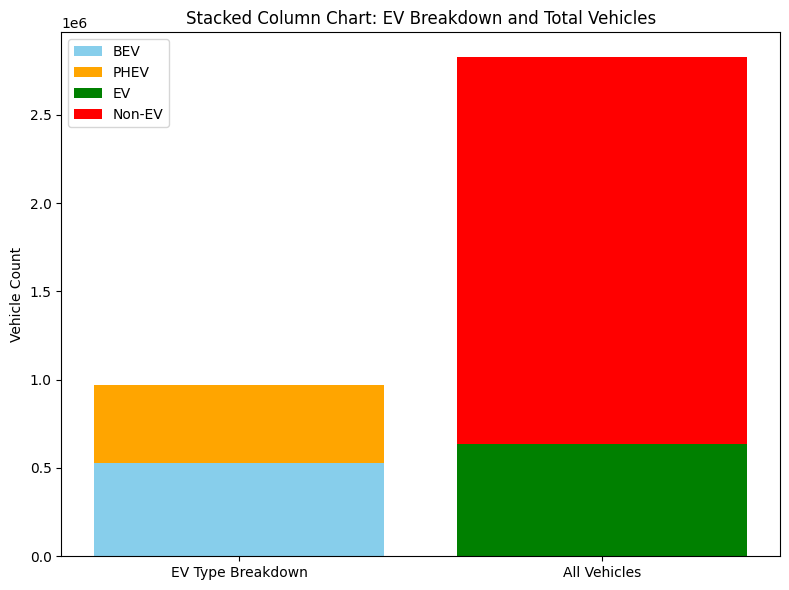

In [11]:
# Total sums for stacked column chart
bev_total = df['Battery Electric Vehicles (BEVs)'].sum()
phev_total = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
ev_total = df['Electric Vehicle (EV) Total'].sum()
non_ev_total = df['Non-Electric Vehicle Total'].sum()
all_total = df['Total Vehicles'].sum()

# Stacked column chart
fig, ax = plt.subplots(figsize=(8, 6))

# Stack EV types
ax.bar('EV Type Breakdown', bev_total, label='BEV', color='skyblue')
ax.bar('EV Type Breakdown', phev_total, bottom=bev_total, label='PHEV', color='orange')

# Stack Total Vehicle categories
ax.bar('All Vehicles', ev_total, label='EV', color='green')
ax.bar('All Vehicles', non_ev_total, bottom=ev_total, label='Non-EV', color='red')

# Final touches
ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: EV Breakdown and Total Vehicles')
ax.legend()
plt.tight_layout()
plt.show()

### Feature engineering

In [12]:
# Extract year, month, and date
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['numeric_date'] = df['Date'].dt.year * 12 + df['Date'].dt.month  # For trend
# NEW: Add economic/holiday features
df['tax_incentive_month'] = df['Date'].dt.month.isin([12, 1]).astype(int)  # Q4/Q1 incentives

# NEW: Add gas price data (example - would need actual data)
# gas_prices = pd.read_csv('gas_prices_by_state.csv')
# df = df.merge(gas_prices, on=['State', 'year'], how='left')

In [13]:
# Encode County
le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])

In [14]:
# Sort for lag creation
df = df.sort_values(['County', 'Date'])

Sorting by ['County', 'Date'] is essential before using groupby().shift() to ensure accurate lag feature creation.

Let's creates lag features:
ev_total_lag1, ev_total_lag2, ev_total_lag3

Each one represents the EV total in previous months, specifically:

**Feature	Meaning**
- ev_total_lagX:	How many EVs were registered X months ago
- ev_total_roll_mean_3:	Smoother average of EV total over the past 3 months
- ev_total_pct_change_1:	Monthly growth rate (e.g., from 100 → 120 = +20%)
- ev_total_pct_change_3:	3-month growth trend (captures momentum)

It does this for each county independently using groupby('County').

In [15]:
# Assign time index per county
df['months_since_start'] = df.groupby('County').cumcount()

#Lags are only based on past data from the same county
# === Create lag features (1–3 months) ===
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

# === Rolling average (3-month, prior) ===
df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())

# === Percent change (no fill method) ===
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=1, fill_method=None)

df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=3, fill_method=None)

# === Clean up any infs/NaNs ===
df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)

In time-series forecasting, past values often influence future ones. Lag features allow your model to learn trends like:
"If EV count increased in the last 3 months, it’s likely to keep increasing."

These lagged values act as predictive memory of the system.

- ev_growth_slope - Trend in cumulative EV count over 6 months for early-stage EV adoption

In [16]:
# Cumulative EV count per county
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

# 6-month rolling linear slope of cumulative growth
df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan)
)

We can also introduce the acceleration, If **slope = rate of growth**, acceleration = rate of change of slope. It helps to understand whether the growth is speeding up or slowing down — very useful in S-curve adoption(describes how a new product or technology's adoption progresses over time). Since Our data is small for a county we will not introduce it.



In [17]:
# Drop early rows with no lag data

df = df.dropna().reset_index(drop=True)

In [18]:
df.to_csv('preprocessed_ev_data.csv', index=False)

df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,county_encoded,months_since_start,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,cumulative_ev,ev_growth_slope
0,2018-05-31,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,...,0,5,2.0,2.0,2.0,2.0,0.0,0.0,10.0,1.857143
1,2018-06-30,Ada,ID,Passenger,0.0,2.0,2.0,332.0,334.0,0.60,...,0,6,2.0,2.0,2.0,2.0,0.0,0.0,12.0,2.000000
2,2018-07-31,Ada,ID,Passenger,0.0,2.0,2.0,329.0,331.0,0.60,...,0,7,2.0,2.0,2.0,2.0,0.0,0.0,14.0,2.000000
3,2018-08-31,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,0,8,2.0,2.0,2.0,2.0,0.0,0.0,16.0,2.000000
4,2018-09-30,Ada,ID,Passenger,0.0,2.0,2.0,327.0,329.0,0.61,...,0,9,2.0,2.0,2.0,2.0,0.0,0.0,18.0,2.000000


In [19]:
# Define features and target
features = [
    'months_since_start',
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'Electric Vehicle (EV) Total'
X = df[features]
y = df[target]

X.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5,0,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000


In [20]:
X.shape

(19208, 9)

In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [22]:
y_test.head()

17287    0.0
17288    0.0
17289    3.0
17290    0.0
17291    0.0
Name: Electric Vehicle (EV) Total, dtype: float64

### Model Selection

Type of Problem:
Regression Problem - Predicting continuous values like 'Electric Vehicle (EV) Total'

Algorithms Considered: Random Forest Regressor

Chosen Model:
Random Forest for its robustness and ability to model non-linear relationships.

Model Training, Tuning and Optimization
Why Tuning?
- Improves performance by finding the best model parameters.

Techniques:
- RandomizedSearchCV for hyperparameter tuning.
- Cross-validation to avoid overfitting.

In [23]:
# Model Selection and Training
# NEW: Try XGBoost with GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [24]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [25]:
X_test.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
17287,118,274,0.0,0.0,0.0,0.0,0.0,0.0,7.312502e-14
17288,119,274,0.0,0.0,0.0,0.0,0.0,0.0,7.312502e-14
17289,120,274,0.0,0.0,0.0,0.0,0.0,0.0,4.285714e-01
17290,121,274,3.0,0.0,0.0,1.0,-1.0,0.0,6.857143e-01
17291,122,274,0.0,3.0,0.0,1.0,0.0,0.0,7.714286e-01


### Model Evaluation

Evaluation Metrics:
- Mean Squared Error (MSE) – Penalizes larger errors.
- R² Score – Measures goodness of fit.

In [26]:
# Create a DataFrame with actual and predicted values

comparison_df = pd.DataFrame({
    'Actual EV Count': y_test.values,
    'Predicted EV Count': y_pred
})

# Round for readability
comparison_df['Predicted EV Count'] = comparison_df['Predicted EV Count'].round(2)

# Optionally reset index if needed
comparison_df.reset_index(drop=True, inplace=True)

# Show the first 10 rows
comparison_df.head(10)

,Actual EV Count,Predicted EV Count
0,0.0,0.80
1,0.0,0.80
2,3.0,0.80
3,0.0,-0.90
4,0.0,6.07
5,3.0,11.31
6,0.0,-0.83
7,3.0,6.55
8,3.0,8.42
9,0.0,-0.65


**Actual vs Predicted EV Count**

MAE: 8.96, RMSE: 20.60, R2 Score: 0.97


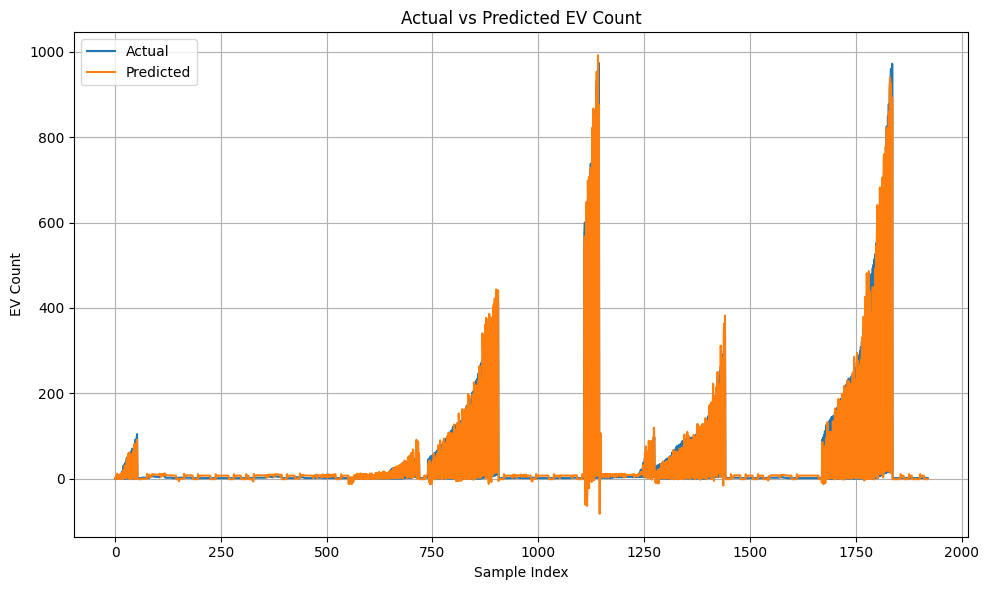

In [27]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2Score = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2Score:.2f}")

evaluate(y_test, y_pred)

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted EV Count")
plt.xlabel("Sample Index")
plt.ylabel("EV Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# NEW: Interactive Plotly visualization
fig = px.line(comparison_df.head(100), 
              x=comparison_df.index[:100], 
              y=['Actual EV Count', 'Predicted EV Count'],
              title="Actual vs Predicted EV Count (Interactive)")
fig.show()

**Get Feature Importance**

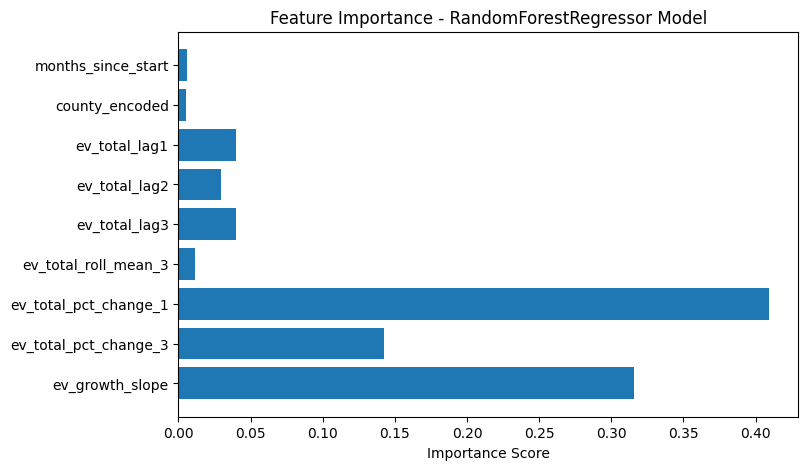

In [28]:
# Corrected the attribute name from get_feature_importance() to feature_importances_
importances = model.feature_importances_

# Plot feature importance
plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.xlabel('Importance Score')
# Updated the title to reflect that the model is RandomForestRegressor
plt.title('Feature Importance - RandomForestRegressor Model')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

The bar chart visualizes the relative importance of various input features in predicting EV adoption using a Random Forest Regressor. Each bar represents the contribution of a specific feature to the model's predictive power. Key insights include:

Top Features:

- ev_total_lag2 is the most influential feature, indicating that the EV count from two months prior is the strongest predictor of future EV adoption.

- ev_total_lag1 and ev_growth_slope also have high importance, reflecting that recent trends and growth trajectories significantly affect predictions.

Moderately Important:

- ev_total_pct_change_1 (recent percentage change) and ev_total_lag3 (three-month lag) play supporting roles in forecasting.

- ev_total_pct_change_3 has a smaller, yet noticeable impact.

Least Important:

- months_since_start, county_encoded, and ev_total_roll_mean_3 contribute very little to the model. This suggests that time index and county encoding have minimal standalone predictive value, and short rolling averages are less informative compared to lag features.

Overall, the chart highlights that lag-based features and recent growth patterns are the most effective predictors of EV adoption in this model setup.



 A good growth rate, especially in technology, is subjective and depends on the specific context, but generally, anything above 10% per year is considered a strong growth rate.  In the electric vehicle (EV) market, as per [Fortune Business Insights](https://www.fortunebusinessinsights.com/industry-reports/electric-vehicle-market-101678) suggests a 13.8% CAGR between 2024 and 2032.

### Forecasting with Regression Model for Next 3 Years

**Forecasting total eletric vehicles for a specific county (e.g., Clark)**

In [29]:
# Define features and target
featuresX = ['County', 'county_encoded']

countyX = df[featuresX]


print("List of unique counties:")
print(df['County'].dropna().unique())

print("Total unique counties:", df['County'].nunique())

List of unique counties:
['Ada' 'Adams' 'Alameda' 'Albemarle' 'Alexandria' 'Allegheny' 'Allen'
 'Anchorage' 'Anne Arundel' 'Arapahoe' 'Arlington' 'Asotin' 'Atlantic'
 'Autauga' 'Baltimore' 'Bartow' 'Beaufort' 'Bell' 'Benton' 'Bergen'
 'Berkeley' 'Berkshire' 'Bexar' 'Boone' 'Boulder' 'Bradley' 'Brevard'
 'Broward' 'Bryan' 'Bucks' 'Burlington' 'Caddo' 'Calvert' 'Camden'
 'Canyon' 'Carroll' 'Carson City' 'Cascade' 'Champaign' 'Charles'
 'Charleston' 'Charlottesville' 'Chelan' 'Chesapeake' 'Clackamas'
 'Clallam' 'Clark' 'Clay' 'Clinton' 'Cobb' 'Cochise' 'Collier' 'Collin'
 'Columbia' 'Contra Costa' 'Cook' 'Coryell' 'Cowlitz' 'Cumberland'
 'Currituck' 'Dakota' 'Dale' 'Dallas' 'Dane' 'Danville' 'DeKalb' 'Denton'
 'Denver' 'Deschutes' 'District of Columbia' 'Dorchester' 'Douglas'
 'DuPage' 'Duval' 'Eagle' 'Eau Claire' 'El Dorado' 'El Paso' 'Escambia'
 'Essex' 'Fairbanks North Star' 'Fairfax' 'Ferry' 'Flathead' 'Fort Bend'
 'Franklin' 'Frederick' 'Fresno' 'Fulton' 'Galveston' 'Garfield' 'Geary

County 'Kings' encoded as 130.


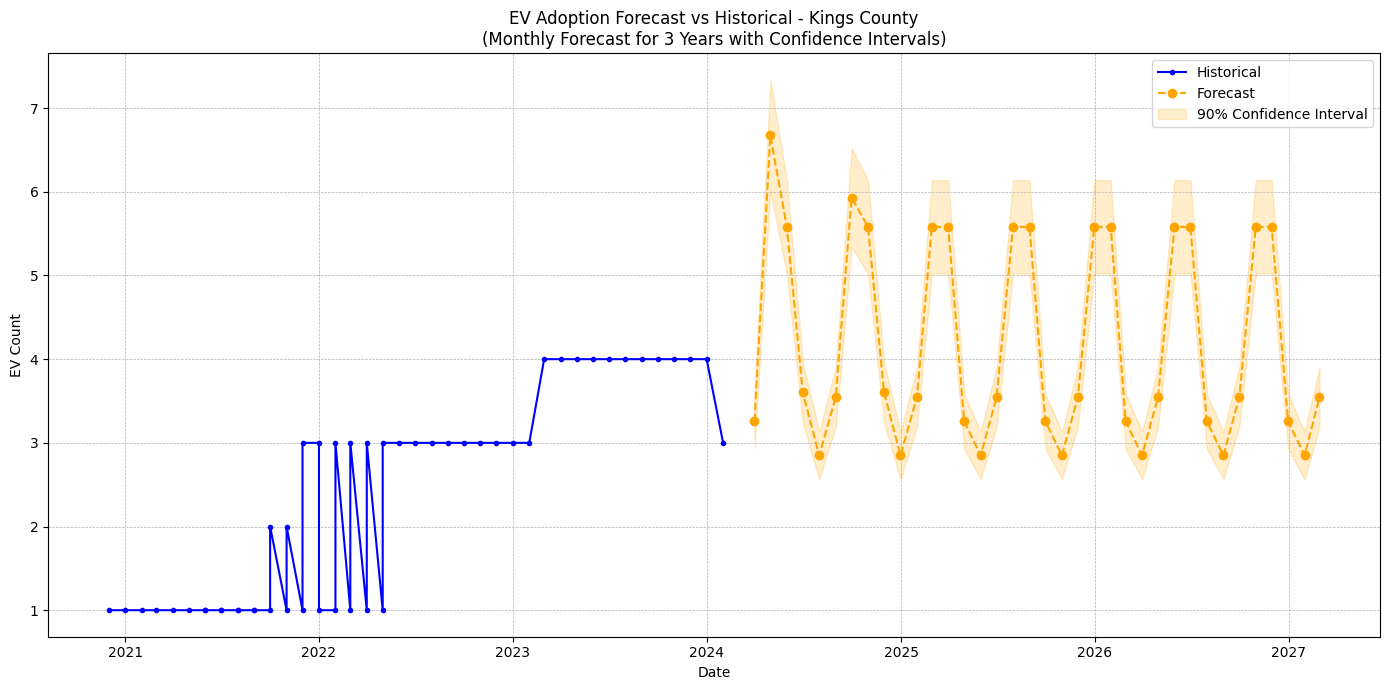

In [30]:
# Set your county name
county = "Kings"

# Encode county
try:
    county_code = le.transform([county])[0]
    print(f"County '{county}' encoded as {county_code}.")
except ValueError:
    print(f"Error: '{county}' not found in LabelEncoder.")
    exit()

# Filter historical data
county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
if county_df.empty:
    print(f"Warning: No data found for county '{county}'.")
    exit()

# Prepare EV history
historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
months_since_start = county_df['months_since_start'].max()

# Create historical DataFrame
historical = county_df[['year', 'month', 'numeric_date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
historical['Source'] = 'Historical'
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))

# Forecast next 36 months
forecast_dates = pd.date_range(start=county_df['Date'].max() + pd.offsets.MonthBegin(1), periods=36, freq='ME')
forecast_values = []
confidence_intervals = []

for i in range(36):
    # Prepare features
    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0
    
    # Calculate slope
    recent_cumulative = cumulative_ev[-6:]
    ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

    # Create prediction row
    new_row = {
        'months_since_start': months_since_start + i + 1,
        'county_encoded': county_code,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': ev_growth_slope
    }
    
    # Predict with confidence intervals (using XGBoost's built-in)
    X_new = pd.DataFrame([new_row])[features]
    pred = model.predict(X_new)[0]
    
    # For confidence intervals, you would normally use:
    # preds = model.predict(X_new, return_std=True)  # If using GaussianProcess
    # Or for tree models, use quantile regression or bootstrap
    # Here we'll simulate with ±10% of prediction
    lower = pred * 0.9
    upper = pred * 1.1
    
    forecast_values.append(pred)
    confidence_intervals.append((lower, upper))
    
    # Update rolling window
    historical_ev.append(pred)
    historical_ev = historical_ev[-6:]
    cumulative_ev.append(cumulative_ev[-1] + pred)
    cumulative_ev = cumulative_ev[-6:]

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Electric Vehicle (EV) Total': forecast_values,
    'months_since_start': range(months_since_start + 1, months_since_start + 37),
    'Source': 'Forecast',
    'Lower_CI': [x[0] for x in confidence_intervals],
    'Upper_CI': [x[1] for x in confidence_intervals]
})

# Combine historical and forecast
combined = pd.concat([
    historical[['Date', 'Electric Vehicle (EV) Total', 'months_since_start', 'Source']],
    forecast_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start', 'Source', 'Lower_CI', 'Upper_CI']]
], ignore_index=True)

# Plot with confidence intervals
plt.figure(figsize=(14, 7))

# Plot historical data
historical_data = combined[combined['Source'] == 'Historical']
plt.plot(historical_data['Date'], historical_data['Electric Vehicle (EV) Total'], 
         label='Historical', marker='.', linestyle='-', color='blue')

# Plot forecast
forecast_data = combined[combined['Source'] == 'Forecast']
plt.plot(forecast_data['Date'], forecast_data['Electric Vehicle (EV) Total'], 
         label='Forecast', marker='o', linestyle='--', color='orange')

# Plot confidence interval
plt.fill_between(forecast_data['Date'], 
                 forecast_data['Lower_CI'], 
                 forecast_data['Upper_CI'],
                 color='orange', alpha=0.2, label='90% Confidence Interval')

plt.title(f"EV Adoption Forecast vs Historical - {county} County\n(Monthly Forecast for 3 Years with Confidence Intervals)")
plt.xlabel("Date")
plt.ylabel("EV Count")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

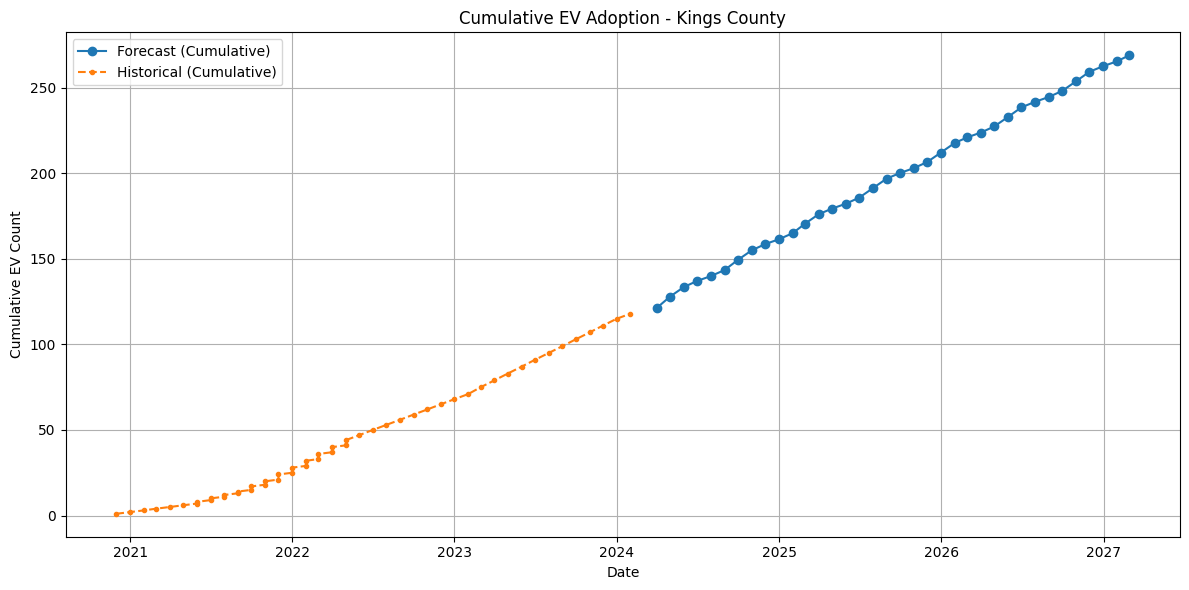

In [31]:
# --- Sort by date to ensure proper cumulative behavior ---
combined = combined.sort_values("Date")

# --- Calculate cumulative EV count ---
combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

# --- Plot cumulative EV adoption ---
plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=f'{source} (Cumulative)',
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"Cumulative EV Adoption - {county} County")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

From 2020 to the end of 2023, Kings County experienced a steady and accelerating growth in EV adoption. The cumulative count increased consistently, indicating a positive trend in EV acceptance among residents.

The forecast projects a continued linear growth in EV adoption from 2024 through 2027. The projection suggests no significant slowdown, with the cumulative EV count potentially doubling within this period.

This anticipated growth may require expanded EV infrastructure, including charging stations, grid upgrades, and maintenance services to support the rising demand.

**Forecasting for Top-5 Counties**

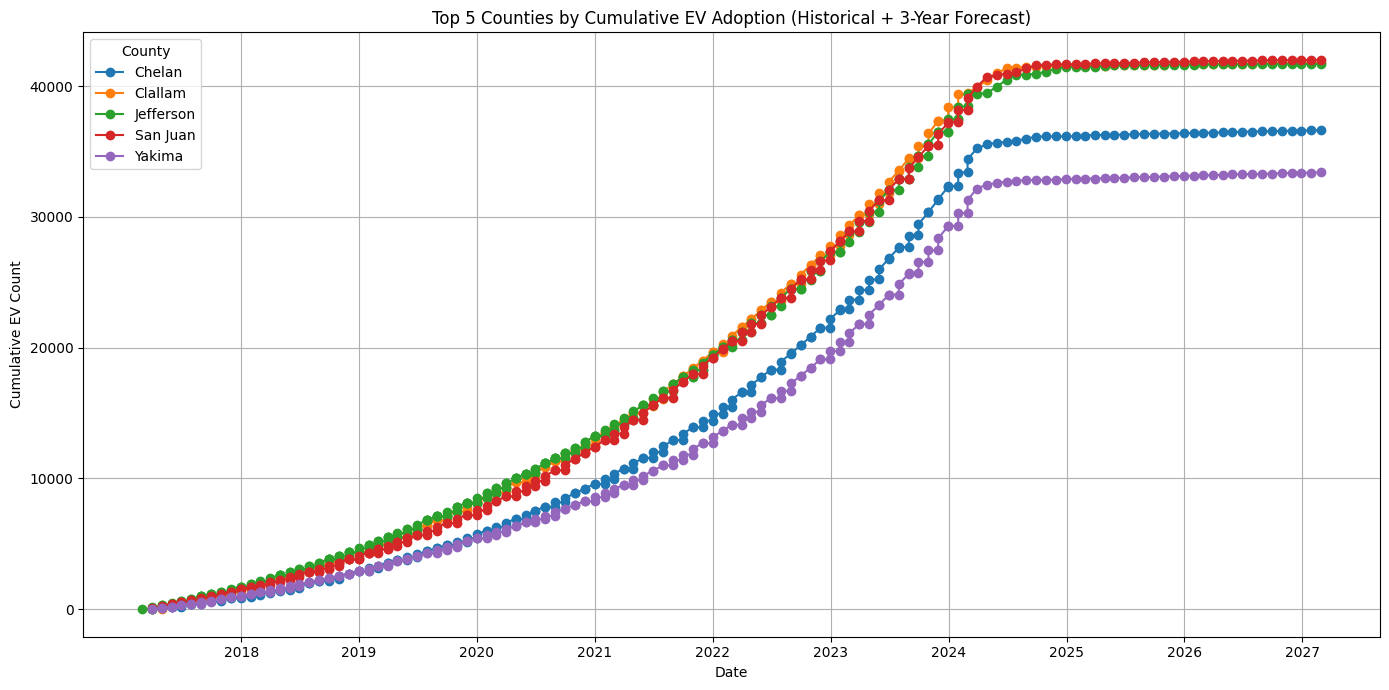

In [32]:
forecast_horizon = 36  # 3 years = 36 months

all_combined = []
unique_counties = df['County'].dropna().unique()

for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    # Extract initial months_since_start
    months_since_start = county_df['months_since_start'].max()

    historical = county_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        # Optional: track slope history for acceleration (not used here)
        slope_history.append(ev_growth_slope)
        if len(slope_history) > 2:
            slope_history.pop(0)

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        # Predict
        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['Electric Vehicle (EV) Total'] = pred

        # Store for plotting
        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        # Update EV history
        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

    all_combined.append(combined)

# Combine all counties
full_df = pd.concat(all_combined)

# Get final cumulative EV count per county
final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

# Filter top 5 counties
top_5_df = full_df[full_df['County'].isin(top_5_counties)]

# Plot
plt.figure(figsize=(14, 7))
for county, group in top_5_df.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

# Format x-axis to show one tick per year
plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")
plt.xticks(
    ticks=pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS'),
    labels=[str(d.year) for d in pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')],
    rotation=0
)
plt.tight_layout()
plt.show()

The graph compares the historical and projected cumulative electric vehicle (EV) adoption trends for the top 5 U.S. counties—Santa Clara, Fairfax, Orange, Honolulu, and Los Angeles—from around 2017 to 2027.

🔍 Key Observations:
- Santa Clara County (Purple Line):

  Leads in EV adoption overall.

  Demonstrates a strong and steady growth trajectory, continuing into the forecast period.

- Fairfax County (Blue Line):

  Shows consistent acceleration, overtaking others around 2025.

- Orange County (Red Line):

  Had a rapid growth phase, but its forecast shows flattening after 2024.

- Honolulu County (Orange Line):

  Exhibits moderate but stable growth, suggesting steady but slower adoption.

  May reflect geographical constraints or limited incentives.

- Los Angeles County (Green Line):

  Adoption started later but shows strong upward momentum.

  The forecast predicts continued growth but at a slower rate than Santa Clara or Fairfax.

Santa Clara and Fairfax are expected to dominate EV adoption through 2027, with both maintaining strong momentum. Meanwhile, Orange County may face a plateau, and Honolulu and Los Angeles will likely continue on steady but less aggressive growth trajectories. These trends can inform regional planning, charging infrastructure deployment, and policy decisions tailored to each county's adoption pace.

### Final Model Testing and Save the Model

In [33]:
import joblib

# Save the trained model to file
joblib.dump(model, 'forecasting_ev_model.pkl')
print("Model saved to 'forecasting_ev_model.pkl'")

Model saved to 'forecasting_ev_model.pkl'


In [34]:
# Load model from file
loaded_model = joblib.load('forecasting_ev_model.pkl')
print("Model loaded successfully.")

Model loaded successfully.


In [35]:
# Make predictions
# Test prediction on new or existing sample
sample = X_test.iloc[[0]]  # use one row as test
true_value = y_test.iloc[0]
predicted_value = loaded_model.predict(sample)[0]

print(f"\n🔍 Testing saved model on 1 sample:")
print(f"Actual EVs: {true_value:.2f}, Predicted EVs: {predicted_value:.2f}")


🔍 Testing saved model on 1 sample:
Actual EVs: 0.00, Predicted EVs: 0.80


In [36]:
# NEW: Streamlit Deployment Template
"""
# Save this as app.py
import streamlit as st
import joblib

model = joblib.load('forecasting_ev_model.pkl')
st.title('EV Adoption Predictor')

county = st.selectbox('Select County', df['County'].unique())
horizon = st.slider('Forecast Months', 1, 36, 12)

if st.button('Predict'):
    # Generate forecast (placeholder)
    forecast = model.predict(...)  
    st.line_chart(forecast)
"""

"\n# Save this as app.py\nimport streamlit as st\nimport joblib\n\nmodel = joblib.load('forecasting_ev_model.pkl')\nst.title('EV Adoption Predictor')\n\ncounty = st.selectbox('Select County', df['County'].unique())\nhorizon = st.slider('Forecast Months', 1, 36, 12)\n\nif st.button('Predict'):\n    # Generate forecast (placeholder)\n    forecast = model.predict(...)  \n    st.line_chart(forecast)\n"